In [85]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy 

intreday_omega = r"C:\\physics_masters\\data\\Bossa public market data\\pub\\intraday\\omega"
daily_omega = r"C:\\physics_masters\\data\\Bossa public market data\\pub\\daily\\omega"

intraday_mstock = r"C:\\physics_masters\\data\\Bossa public market data\\pub\\intraday\\mstock"
daily_mstock = r"C:\\physics_masters\\data\\Bossa public market data\\pub\\daily\\mstock"


# Data examination and selction

### specifying years of interest, merging data from different companies

In [86]:
def get_dataframes(data_dir, start_date, threshold):
    dataframes = {}
    for filename in os.listdir(data_dir):
        path = os.path.join(data_dir, filename)
        name = filename.replace('.prn', '')
        df = pd.read_csv(path, delimiter=',', header=0, parse_dates=['Date'], usecols=['Date', 'Close'])
        df = df[df['Date'] >= start_date].set_index('Date')
        if len(df) > threshold:
            df.rename(columns={"Close": name}, inplace=True)
            dataframes[name] = df
    return dataframes

In [132]:
N = 4
threshold = 0.683 *N *365
time_delta = pd.Timedelta(days=365*N)
end_date = pd.to_datetime('2024-06-20')
start_date = end_date - time_delta

dataframes_dict = get_dataframes(daily_omega, start_date, threshold)

merged_df = pd.concat(dataframes_dict.values(), axis=1, join='outer')

print(f'{len(merged_df)} time stamps and {len(merged_df.dropna())} full time stamps')

companies = merged_df.columns

print(f'Number of companies: {len(companies)}')
print(companies)


1006 time stamps and 944 full time stamps
Number of companies: 174
Index(['06MAGNA', '11BIT', 'ABPL', 'ACAUTOGAZ', 'ACTION', 'AGORA', 'AGROTON',
       'AILLERON', 'AIRWAY', 'ALIOR',
       ...
       'WIG20TR', 'WIG30', 'WIG30TR', 'WIRTUALNA', 'WITTCHEN', 'XTB', 'XTPL',
       'ZEPAK', 'ZREMB', 'ZUE'],
      dtype='object', length=174)


### selecting companies present in GICS classification file

In [140]:
class_file = r"C:\\physics_masters\\data\\GICS_classification.csv"

class_df = pd.read_csv(class_file, delimiter=',', header=None, names=['Company', 'Name', 'Sector', 'Subsector'], skipinitialspace=True, usecols=[0, 1, 2, 3])

sectors = ['Consumer Discretionary', 'Consumer Staples',  'Health Care', 'Communication Services', 'Telecommunication Services', 'Real Estate']
sec1 = ['Financials', 'Communication Services', 'Utilities', 'Energy']


selected_companies_df = class_df[class_df['Name'].isin(companies) & class_df['Sector'].isin(sec1)]

print(f'final number of companies: {len(selected_companies_df)}')

merged_df = merged_df[selected_companies_df['Name']]
print(f'{len(merged_df)} time stamps and {len(merged_df.dropna())} full time stamps')

selected_companies_df

final number of companies: 22
1006 time stamps and 998 full time stamps


,Company,Name,Sector,Subsector
0,PKO BP SA,PKOBP,Financials,Banks
1,Orlen SA,PKNORLEN,Energy,Oil
2,Santander Bank Polska SA,SANPL,Financials,Banks
3,PZU SA,PZU,Financials,Insurance
5,Bank Pekao SA,PEKAO,Financials,Banks
11,CD Projekt SA,CDPROJEKT,Communication Services,Media & Entertainment
13,PGE Polska Grupa Energetyczna SA,PGE,Utilities,Utilities
16,BNP Paribas Bank Polska SA,BNPPPL,Financials,Banks
17,Alior Bank SA,ALIOR,Financials,Banks
21,Orange Polska SA,ORANGEPL,Communication Services,Telecommunication Services


In [134]:
selected_companies_df.groupby('Sector').count()[['Company']].sort_values(by='Company', ascending=False)

,Company
Sector,
Financials,9
Materials,6
Communication Services,5
Utilities,5
Energy,3


In [55]:
# pominięte - nie było w csv gics
companies.difference(class_df[1])

Index(['11BIT', 'ACTION', 'AGORA', 'AMICA', 'ASBIS', 'BIOTON', 'BLOOBER',
       'CIGAMES', 'COMARCH', 'CORMAY', 'ETFSP500', 'FARM51', 'FORTE'],
      dtype='object')

# Data anomalies

### Example: AMREST
stock split in 2018

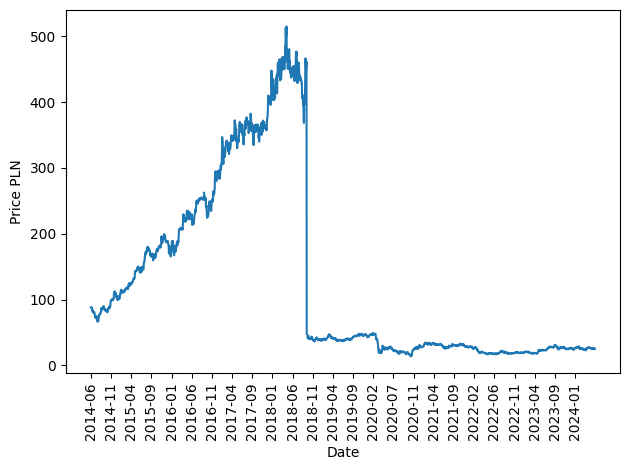

In [56]:
plt.plot(merged_df['AMREST'])
plt.xticks(range(0, len(merged_df), 100), merged_df['Date'][::100].dt.strftime('%Y-%m'), rotation=90)
plt.xlabel('Date')
plt.ylabel('Price PLN')
plt.tight_layout()


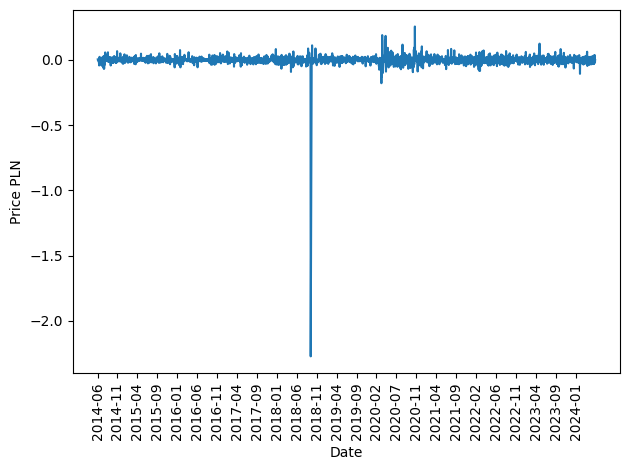

In [57]:
plt.plot(np.log(merged_df['AMREST']).diff().dropna())
plt.xticks(range(0, len(merged_df), 100), merged_df['Date'][::100].dt.strftime('%Y-%m'), rotation=90)
plt.xlabel('Date')
plt.ylabel('Price PLN')
plt.tight_layout()

In [58]:
logreturns = np.log(merged_df[selected_companies_df['Name']].ffill().dropna()).diff().dropna()
logreturns['AMREST'].quantile(0.995)


np.float64(0.08671561134829853)

# Stationary correlations

### calculate log returns, truncate outliers, clear nan's

<Axes: xlabel='Date'>

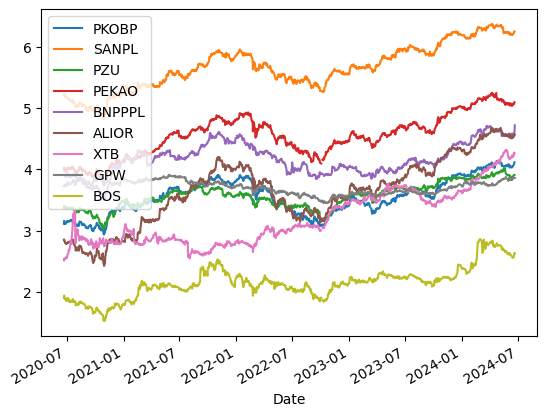

In [128]:
np.log(merged_df)['2020':'2024'].plot()

In [141]:
m_df = merged_df.copy()
m_df = m_df.ffill() # only several na's to be removed - fill in with previous values

m_df_log_diff = np.log(m_df).diff().dropna()

for name in m_df_log_diff.columns:
    
    q_low = m_df_log_diff[name].quantile(0.001)
    q_hi  = m_df_log_diff[name].quantile(0.999)

    m_df_log_diff.loc[(m_df_log_diff[name] > q_hi) | (m_df_log_diff[name] < q_low), name] = np.nan

print(len(m_df_log_diff))
m_df_log_diff = m_df_log_diff.dropna() #remove first row and outliers
len(m_df_log_diff) # final number of time stamps

1005


948

### correlation matrix, clustering

In [15]:
from scipy.cluster.hierarchy import dendrogram, linkage, leaves_list
from scipy.spatial import distance

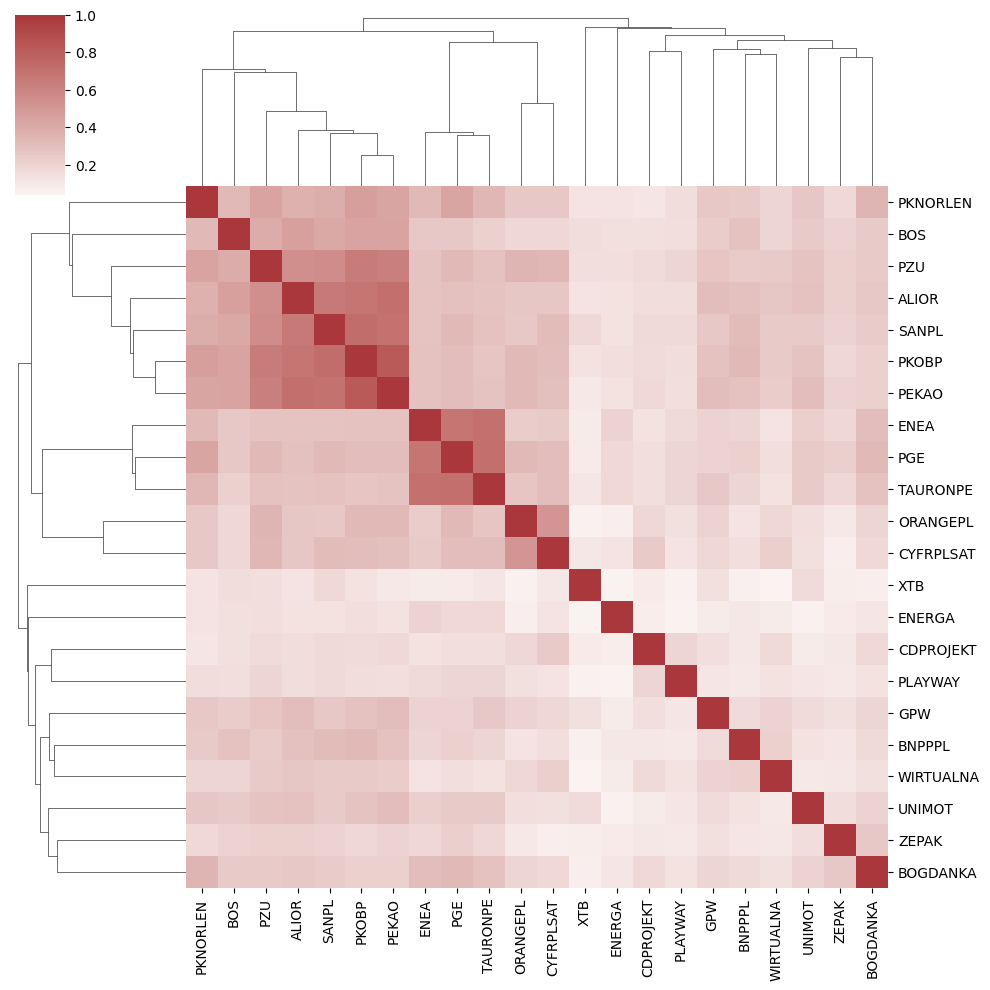

In [142]:

corr = m_df_log_diff.corr(method='pearson')

dist = 1-corr

condensed_dist = distance.pdist(dist)

Z = linkage(condensed_dist, method='average', metric='euclidean')
Zcol = linkage(distance.pdist(corr.T), method='average', metric='euclidean')

res = sns.clustermap(corr, cmap="vlag", center=0, row_linkage=Z, col_linkage=Zcol)


In [79]:
eigenvals, eigenvec = np.linalg.eig(corr.to_numpy())
np.sort(eigenvals/np.sum(eigenvals))[::-1]

array([0.20571605, 0.05911481, 0.05320095, 0.04644911, 0.04576611,
       0.04323836, 0.042117  , 0.04110046, 0.04036929, 0.03997799,
       0.03892192, 0.0380954 , 0.03705588, 0.0359948 , 0.03487164,
       0.03376153, 0.03279098, 0.03173332, 0.02956475, 0.02777752,
       0.02544882, 0.01693334])

In [83]:
-eigenvec[:, 0] # first eigenvector

array([0.17616437, 0.29929282, 0.24732733, 0.28616231, 0.16634854,
       0.18568177, 0.21819104, 0.23906056, 0.29010358, 0.1509021 ,
       0.20168901, 0.20526841, 0.2517503 , 0.14067396, 0.19694643,
       0.1246363 , 0.20542444, 0.14510798, 0.21131235, 0.12480841,
       0.22495612, 0.26095591])

In [97]:
def get_labels(leaves, Z, labels, sectors=None):
    
    labels =  ' '  + sectors + '\n' if sectors is not None else labels +'\n'

    n_items = len(labels)
    labels_ordered = labels[leaves_list(Z)]
    
    leaves_occupation = np.append(np.full(n_items, 1), Z[:, 3])

    divisions = leaves_occupation[leaves].astype(int)

    result = []
    index = 0
    for k in divisions:
        result.append(''.join(labels_ordered[index:index + k]))
        index += k
    return result

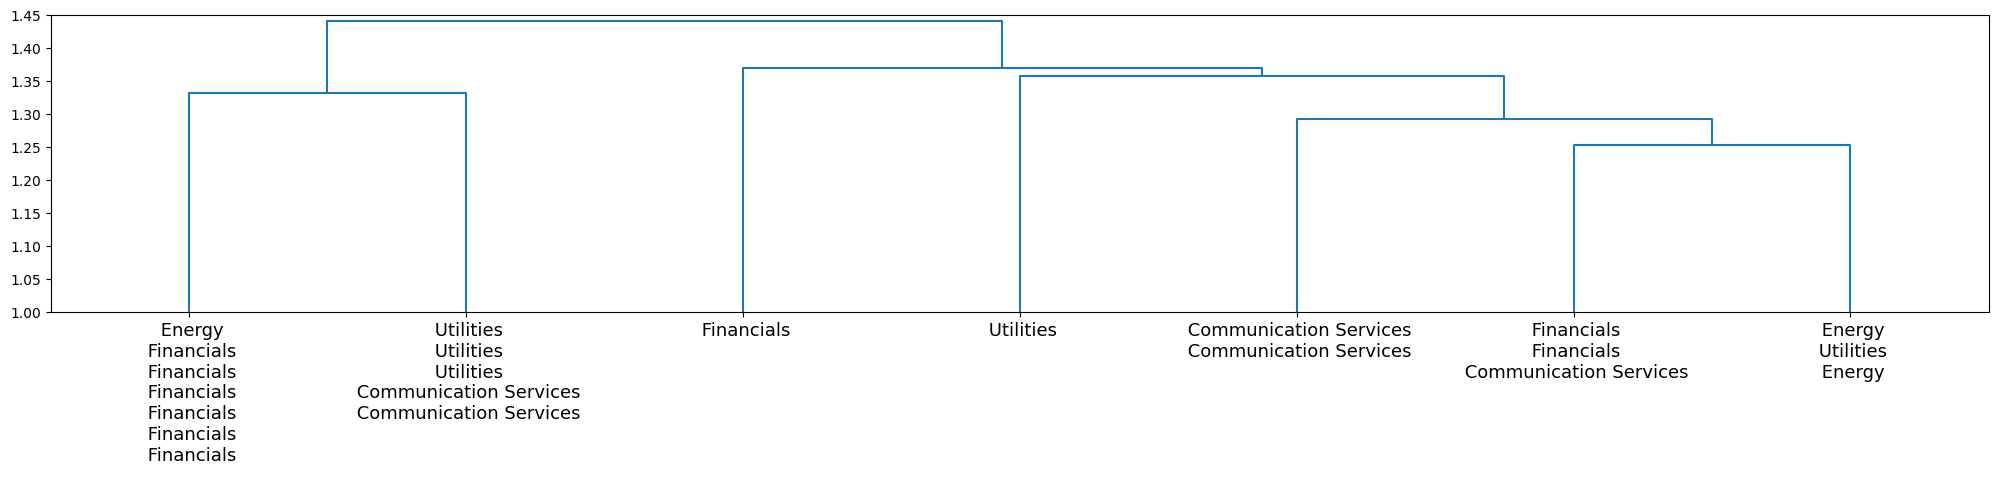

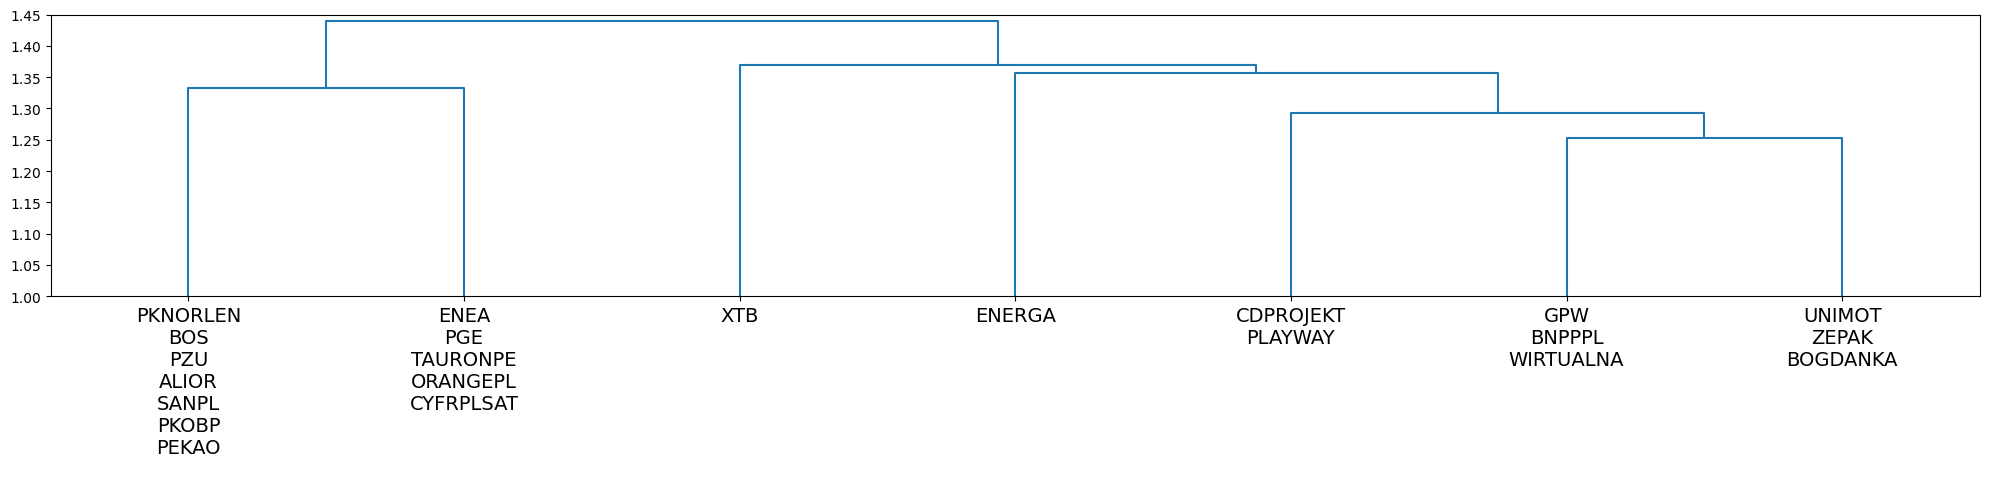

In [144]:
labs = selected_companies_df['Name'].values
sects = selected_companies_df['Sector'].values
p = 7
fontsize = 14
mode = 'lastp'
ylim_b = 1


fig, ax = plt.subplots(figsize=(20, 5))

dendro = dendrogram(Z, labels=selected_companies_df['Name'].values, leaf_rotation=90, p=p, truncate_mode=mode, no_labels=True)
plt.xticks(10*np.arange(len(dendro['ivl']))+5, get_labels(dendro['leaves'], Z, labs, sects), fontsize = fontsize-1, rotation=0)

plt.tight_layout()
plt.ylim(ylim_b, 1.45)
plt.show()

fig, ax = plt.subplots(figsize=(20, 5))

dendro = dendrogram(Z, labels=selected_companies_df['Name'].values, leaf_rotation=90, p=p, truncate_mode=mode, no_labels=True )
plt.xticks(10*np.arange(len(dendro['ivl']))+5, get_labels(dendro['leaves'], Z, labs), rotation=0, fontsize = fontsize)
plt.ylim(ylim_b, 1.45)
plt.tight_layout()

In [45]:
def calculate_pvalues(df):
    df = df.dropna()  # Drop rows with NaNs
    cols = df.columns
    pvals = pd.DataFrame(np.ones((len(cols), len(cols))), columns=cols, index=cols)

    for i in range(len(cols)):
        for j in range(i+1, len(cols)):
            r, p = scipy.stats.pearsonr(df[cols[i]], df[cols[j]])
            pvals.iloc[i, j] = p
            pvals.iloc[j, i] = p

    np.fill_diagonal(pvals.values, 0)
    return pvals

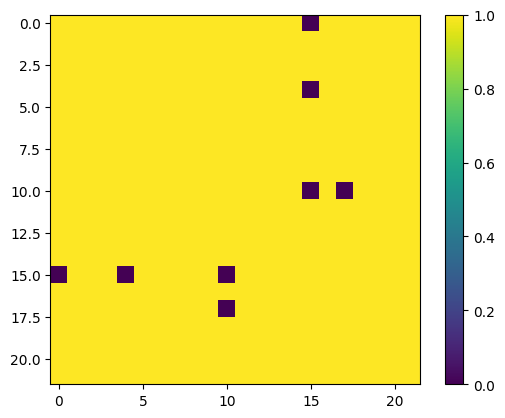

In [56]:
p = calculate_pvalues(m_df[difflogcols])
plt.imshow(p<0.001)
plt.colorbar()

# non-stationary case

In [86]:
difflogcols = [col for col in m_df.columns if 'DifflogClose' in col]

def I0(t):
    return np.mean(m_df.iloc[t][difflogcols])

def D(tau):
    t_start = tau
    t_end = len(m_df)
    denominator = np.mean([I0(t)**2 for t in range(t_start, t_end)])
    
    matrix = m_df.iloc[t_start:t_end][difflogcols].to_numpy()
    I0s_disp = np.array([I0(t) for t in range(0, t_end - tau)])

    numerator = (matrix.T*I0s_disp) @ matrix / matrix.shape[0]
    
    return numerator/denominator


In [ ]:
from ipywidgets import interact, IntSlider

# Your D(tau) must already be defined
# And m_df + difflogcols available in scope

@interact(tau=IntSlider(min=1, max=500, step=100, value=1, description='τ'))
def plot_D_tau(tau):
    D_tau = D(tau)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(D_tau, cmap="coolwarm", center=0, 
                xticklabels=difflogcols, yticklabels=difflogcols, square=True)
    plt.title(f"D(τ={tau})")
    plt.tight_layout()
    plt.show()

interactive(children=(IntSlider(value=1, description='τ', max=500, min=1, step=100), Output()), _dom_classes=(…